(theory)=
# The Hierarchical Gaussian Filter
In this notebook, we introduce the main oncepts on which the Hierarchical Gaussian Filter (HGF) is based. We describe the main equations and illustrate the examples with Python code. We start with the generative model of the HGF, which describes how the model assume that the data is being generated. This generative structure is then used to filter the observation (i.e. the sensory part of the model), which is then used by the agent to produce behaviors (i.e. the action part of the model). Next, we show how this model can be "inverted" and used by an agent to infer parameter values that generated the sensory inputs. From there, we discuss the notion of prediction error and how derivations of the model can be used to infer probability densities given observed behavioural outcomes.

## The generative model

To illustrate the generative model on which the HGF is based, we will start with a simple  two-level continuous HGF (see also the tutorial {ref}`continuous_hgf`). The generative model that underpine the continuous HGF is a generalisation of the [Gaussian Random Walk](https://en.wikipedia.org/wiki/Random_walk#Gaussian_random_walk) (GRW). A GRW generate a new observation $x_1^{(k)}$ at each time step $k$ from a normal distribution and using the previous observation $x_1^{(k-1)}$ such as:

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k-1)}, \sigma^2)
$$

where $\sigma^2$ is the variance of the distribution. In the example below, we use $\sigma^2 = 1$ and $x_1^{(0)} = 0$.

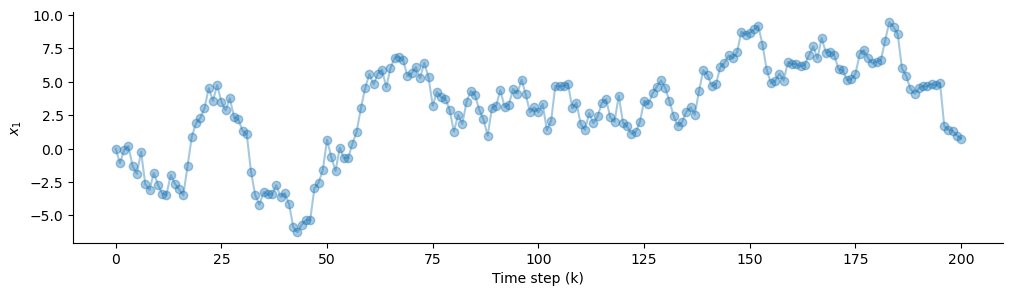

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

np.random.seed(123)

# random walk
x_1 = np.cumsum(np.random.normal(loc=0, scale=1, size=200))  # GRW
x_1 = np.insert(x_1, 0, 0)  # starting at 0

plt.figure(figsize=(12, 3))
plt.plot(x_1, "o-", alpha=.4);
plt.xlabel("Time step (k)");
plt.ylabel("$x_{1}$");
sns.despine()

This simple process will be our first building block. Importantly here, the variability of the sensory input is constant across time: even if we don't know exactly in which direction the time series is going to move in the future, we know that is is unlikely to make certain kind of big jumps, because it is controlled by a fixed parameter, the variance $\sigma^2$. 

### Volatility coupling
Now, we can also decide to change that and let the variance itself being a stochastic process generated by another randome walk. The HGF fundamentaly captitalize on this notion and generalize the standard GRW by letting the variance $\sigma^2$ being controlled by a higher level node.

If we take as example the two-level continuous HGF {cite:p}`2014:mathys`, the model is constituded of two states of interest, $x_1$ and $x_2$. $x_1$ is performing a GRW as previously defined, but it is also paired with $x_2$ to each other via *volatility coupling*. This means that for state $x_1$, the mean of the Gaussian random walk on trial $k$ is given by its previous value $x_1^{(k-1)}$, while the step size (or variance) depends on the current value of the higher level state, $x_2^{(k)}$.

$$
x_1^{(k)} \sim \mathcal{N}(x_1^{(k)} | x_1^{(k-1)}, \, f(x_2^{(k)}))
$$

where the exact dependency is of the form

$$
    f(x_2^{(k)}) = \exp(\kappa_1 x_2^{(k)} + \omega_1)
$$

with $\kappa$ as scalling parameter (by defaults in most case it is set to `1` which indicates a complete volatility coupling), and $\omega_1$ being the *evolution rate*, also refered as the tonic part of the variance, the part that is not inherited from parent nodes.

At the higher level of the hierarchy (here the second level), the nodes are not inheriting anything from their parents anymore, and only rely on their own variance:

$$
x_2^{(k)} \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \, \exp(\omega_2))
$$

The model described above can be implemented in Python as the following:

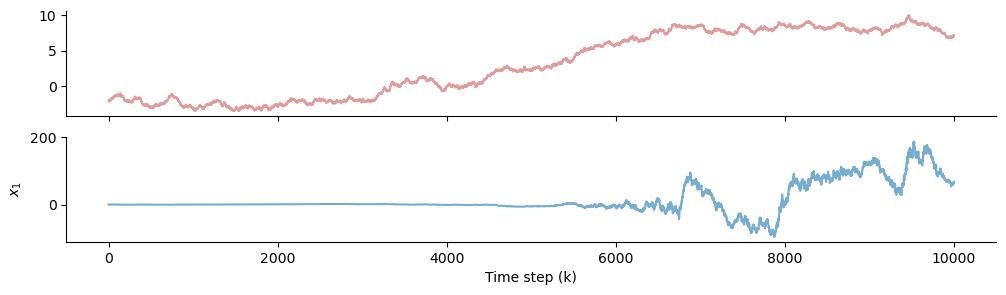

In [2]:
np.random.seed(123)
kappa_1 = 1.0
omega_1 = -6.0
omega_2 = -6.0
mu_1 = 0.0
mu_2 = -2.0
x_1 = [0]
x_2 = [-2]

# two-level hierarchical gaussian random walk
for i in range(10000):

    # x2
    pi_2 = np.exp(omega_2)
    mu_2 = np.random.normal(mu_2, pi_2**.5)
    x_2.append(mu_2)

    # x1
    pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
    mu_1 = np.random.normal(mu_1, pi_1**.5)

    x_1.append(mu_1)

_, axs = plt.subplots(figsize=(12, 3), nrows=2, sharex=True)
axs[0].plot(x_2, "-", color="indianred", alpha=.6);

axs[1].plot(x_1, "-", alpha=.6);
axs[1].set_xlabel("Time step (k)");
axs[1].set_ylabel("$x_{1}$");
sns.despine()

In this example, it becomes apparent that the volatility of the observation is not constant in time anymore, but depends on the values observed at the level above. 

### Value coupling

This distant influence of one node on another is called *volatility coupling* (see below). However, a higher-level state can also have influence on a lower-level state by influencing its mean instead of its variance. In that case, the mean of the Gaussian random walk at one level is a function not only of its own previous value, but also the current value of the higher-level state. Such model can be formalized as follow:

$$
    x_1^{(k)} \sim \mathcal{N}(x_1^{(k)} | x_1^{(k-1)} + \alpha_{1} x_2^{(k)}, \, \exp(\omega_1)) \\
    x_2^{(k)} \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \, \exp(\omega_2))
$$

where $\alpha$ is the value coupling between the two nodes.

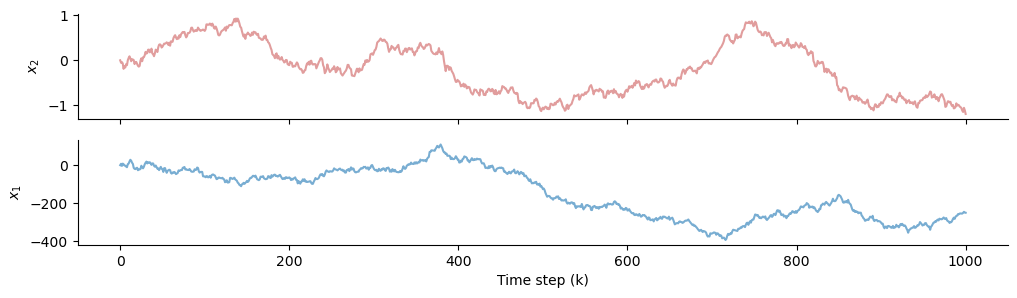

In [3]:
np.random.seed(123)
alpha_1 = 1.0
omega_1, omega_2 = 4.0, -6.0
mu_1, mu_2 = 0.0, 0.0
x_1 = [0]
x_2 = [0]

# two-level hierarchical gaussian random walk
for i in range(1000):

    # x2
    pi_2 = np.exp(omega_2)
    mu_2 = np.random.normal(mu_2, pi_2**.5)
    x_2.append(mu_2)

    # x1
    pi_1 = np.exp(omega_1)
    mu_1 = np.random.normal(mu_1 + (alpha_1 * mu_2), pi_1**.5)
    x_1.append(mu_1)

_, axs = plt.subplots(figsize=(12, 3), nrows=2, sharex=True)
axs[0].plot(x_2, "-", color="indianred", alpha=.6);
axs[1].plot(x_1, "-", alpha=.6);
axs[1].set_xlabel("Time step (k)");
axs[1].set_ylabel("$x_{1}$");
axs[0].set_ylabel("$x_{2}$");
sns.despine()

Finally, volatility and value coupling can operate at the same time on the same node, like in this example where $x_{1}$ has its values coupled with $x_{2}$ and its volatility coupled with $x_{3}$:

$$
x_1^{(k)}          \sim \mathcal{N}(x_1^{(k)} | x_1^{(k-1)} + \alpha_{1} x_2^{(k)}, \exp(\kappa_1 x_3^{(k)} + \omega_1)) \\
x_2^{(k)}          \sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \, \exp(\omega_2)) \\
x_3^{(k)}          \sim \mathcal{N}(x_3^{(k)} | x_3^{(k-1)}, \, \exp(\omega_3)) \\
$$

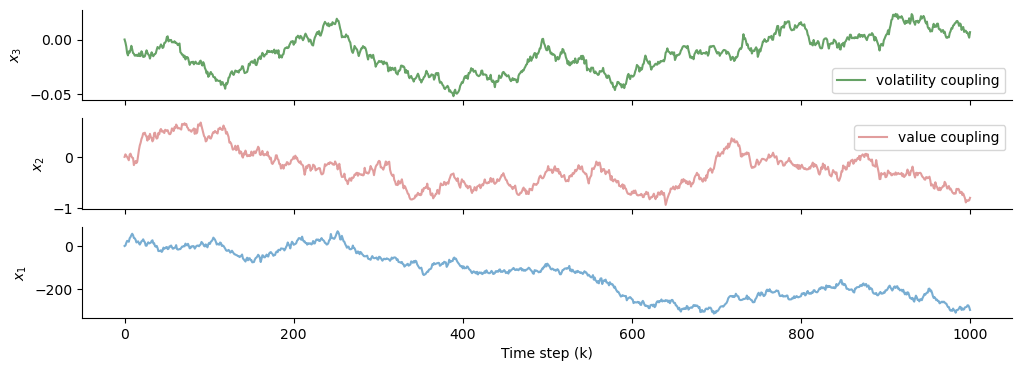

In [4]:
np.random.seed(123)
alpha_1 = 1.0
kappa_1 = 1.0
omega_1, omega_2, omega_3 = 4, -6.0, -12.0
mu_1, mu_2, mu_3 = 0.0, 0.0, 0.0
x_1 = [0]
x_2 = [0]
x_3 = [0]

# two-level hierarchical gaussian random walk
for i in range(1000):
    
    # x3
    pi_3 = np.exp(omega_3)
    mu_3 = np.random.normal(mu_3, pi_3**.5)
    x_3.append(mu_3)

    # x2
    pi_2 = np.exp(omega_2)
    mu_2 = np.random.normal(mu_2, pi_2**.5)
    x_2.append(mu_2)

    # x1
    pi_1 = np.exp(kappa_1 * mu_3 + omega_1)
    mu_1 = np.random.normal(mu_1 + (alpha_1 * mu_2), pi_1**.5)
    x_1.append(mu_1)

_, axs = plt.subplots(figsize=(12, 4), nrows=3, sharex=True)
axs[0].plot(x_3, "-", color="darkgreen", alpha=.6, label="volatility coupling");
axs[1].plot(x_2, "-", color="indianred", alpha=.6, label="value coupling");
axs[2].plot(x_1, "-", alpha=.6);
axs[2].set_xlabel("Time step (k)");
axs[2].set_ylabel("$x_{1}$");
axs[1].set_ylabel("$x_{2}$");
axs[0].set_ylabel("$x_{3}$");
axs[1].legend()
axs[0].legend()
sns.despine()

Based on these principles, any given state in the world can be modelled as having a volatility parent state, a value parent state, both, or none. When the node is orpean, it evolves as a Gaussian random walk around its previous value with fixed step size. Consequently, when inferring on the evolution of these states, the exact belief update equations (which include the computation of new predictions, posterior values, and prediction errors, and represent an approximate inversion of this generative model, see {cite:p}`2011:mathys` depend on the nature of the coupling of a given state with its parent and children states. In particular, the nodes that implement the belief updates will communicate with their value parents via value prediction errors, or **VAPE**s, and via volatility prediction errors, or **VOPE**s, with their volatility parents.

```{figure} ../images/hgf.png
---
name: hgf-fig
---
The two-level and three-level Hierarchical Gaussian Filters for binary or continuous inputs, as described in {cite:p}`2014:mathys,2011:mathys`. The binary HGF has the particularity that it uses a sigmoid transform in the input node to convert continuous values into binary probabilities. For both models, volatility coupling is depicted with dashed lines, and value coupling with straight lines. The three-level HGF has one volatility layer more than the two-level HGF.
```

```{hint}
A one-level HGF for continuous input is a [Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter).
```

For example, the three-level continuous HGF that is illustrated [above](hgf-fig) is built on top of the following generative model:

$$
\begin{align}
u^{(k)}             &\sim \mathcal{N}(u^{(k)} | x_1^{(k)}, \, \sigma_u) \\
x_1^{(k)}           &\sim \mathcal{N}(x_1^{(k)} | x_1^{(k-1)} + \alpha_{2,1} x_2^{(k)}, \, \exp(\kappa_1 \check{x}_1^{(k)} + \omega_1)) \\
\check{x}_1^{(k)}   &\sim \mathcal{N}(\check{x}_1^{(k)} | \check{x}_1^{(k-1)} + \alpha_{3,\check{1}} x_3^{(k)}, \, \exp(\omega_{\check{1}})) \\
x_2^{(k)}           &\sim \mathcal{N}(x_2^{(k)} | x_2^{(k-1)}, \, \exp(\kappa_2 \check{x}_2^{(k)} + \omega_2)) \\
\check{x}_2^{(k)}   &\sim \mathcal{N}(\check{x}_2^{(k)} | \check{x}_2^{(k-1)}, \, \exp(\omega_{\check{2}})) \\
x_3^{(k)}           &\sim \mathcal{N}(x_3^{(k)} | x_3^{(k-1)}, \, \exp(\kappa_3 \check{x}_3^{(k)} + \omega_3)) \\
\check{x}_3^{(k)}   &\sim \mathcal{N}(\check{x}_3^{(k)} | \check{x}_3^{(k-1)}, \, \exp(\omega_{\check{3}})) \\
\end{align}
$$

Note that in this example, all states that are value parents of other states (or outcomes) have their own volatility parent, while states that are volatility parents to other nodes either have a value parent (as state $\check{x}_1$), or no parents (as states $\check{x}_2$ and $\check{x}_3$). This is deliberately so, and we will see these two motifs - every state of a hierarchy has its own volatility estimation, and volatility states only have value parents - reappear in the following chapters.

## Belief updates in the HGF: Computations of nodes

```{note}
The update equations for volatility and value coupling in the generalized hierarchical Gaussian filter have been described in {cite:p}`weber:2023`.
```

The coding examples introduced above illustrated generative models that can simulate data forward from a given volatility structure, with key parameters stochastically fluctuating. HGFs use this as a model of the environment to make sense of new observation, also refered as the sensory part of the HGF, or the filtering part. In this situation, new observation are coming in and the model has to update the volatility structure accordingly (from bottom to top nodes).

In its first description, {cite:p}`2011:mathys` derived a set of simple, one-step update equations that represent changes in beliefs about the hidden states (i.e. the sufficient statistics of the nodes) specified in the generative model. For each state, a belief is held (and updated for every new input) by the agent and described as a Gaussian distribution, fully characterized by its mean $\mu_i^{(k)}$ and its inverse variance, or precision, $\pi_i^{(k)}$ on a given trial $k$ (this is the notation we have been using in the previous examples). We conceptualize each belief as a node in a network, where belief updates involve computations within nodes as well as message passing between nodes. The computations of any observation at each time point $k$ can be ordered in time as shown in the {prf:ref}`belief-update`:

```{prf:algorithm} Belief update
:label: belief-update

For $i$ a {term}`node` in a probabilistic network at time $k$, with children at $i-1$ and parent at $i+1$

1. {term}`Prediction`
    Compute $\mathrm{prediction}^{(k)}_i$ 
    &larr; receive $\mathrm{PE}^{(k)}_{i-1}$ from $\mathrm{node}_{i-1}$

2. Update  
    compute $\mathrm{posterior}^{(k)}_i$  
    **given** $\mathrm{PE}^{(k)}_{i-1}$ and $\mathrm{prediction}^{(k)}_i$  
    &rarr; send $\mathrm{posterior}^{(k)}_i$ to $\mathrm{node}_{i-1}$

3. {term}`prediction error` 
    compute $\mathrm{PE}^{(k)}_i$  
    **given** $\mathrm{prediction}^{(k)}_i$ and $\mathrm{posterior}^{(k)}_i$  
    &rarr; send $\mathrm{PE}^{(k)}_i$ to $\mathrm{node}_{i+1}$  
    &larr; receive $\mathrm{posterior}^{(k)}_{i+1}$ from $\mathrm{node}_{i+1}$  

4. {term}`Prediction`  
    compute $\mathrm{prediction}^{(k+1)}_i$  
    **given** $\mathrm{posterior}^{(k)}_i$ and $\mathrm{posterior}^{(k)}_{i+1}$  

```

The exact computations in each step depend on the nature of the coupling (via {term}`VAPE`s vs. {term}`VOPE`s) between the parent and children nodes.

```{note}
We have placed the {term}`Prediction` step in the end of the update loop. This is because usually, we think about the beginning of a timepoint trial as starting with receiving a new input, and of a prediction as being present before that input is received (this is especially relevant to model time points as trial in an experiemnts). However, in some variants of the HGF the prediction also depends on the time that has passed in between trials, which is something that can only be evaluated once the new input arrives - hence the additional computation of the (current) prediction in the beginning of the trial. Conceptually, it makes most sense to think of the prediction as happening continuously between trials. For implementational purposes, it is however most convenient to only compute the prediction once the new input (and with it its arrival time) enters. This ensures both that the posterior means of parent nodes have had enough time to be sent back to their children for preparation for the new input, and that the arrival time of the new input can be taken into account appropriately.
```

## Computations for VAPE coupling

The exact computations of the {term}`Update` depend on the nature of the coupling with the child node(s), while both the {term}`Prediction error` and the {term}`Prediction` step depend on the coupling with the parent node(s).

### Update

````{prf:definition}
:label: vape-update

If Node $i$ is the value parent of Node $i-1$, then the following update equations apply to Node $i$:

$$
\begin{align}
\pi_i^{(k)} &= \hat{\pi}_i^{(k)} + \alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)}\\
\mu_i^{(k)} &= \hat{\mu}_i^{(k)} + \frac{\alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)}} {\alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)} + \hat{\pi}_{i}^{(k)}} \delta_{i-1}^{(k)}
\end{align}
$$

We note here that we can let the update of the precision happen first, and therefore use it for the update of the mean:

$$
\begin{align}
\pi_i^{(k)} &= \hat{\pi}_i^{(k)} + \alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)}\\
\mu_i^{(k)} &= \hat{\mu}_i^{(k)} + \frac{\alpha_{i-1,i}^2 \hat{\pi}_{i-1}^{(k)}} {\pi_i^{(k)}} \delta_{i-1}^{(k)}
\end{align}
$$
````

In sum, at the time of the update, Node $i$ needs to have access to the following quantities:

* Its own predictions: $\hat{\mu}_i^{(k)}$, $\hat{\pi}_i^{(k)}$  
* Coupling strength: $\alpha_{i-1,i}$  
* From level below: $\delta_{i-1}^{(k)}$, $\hat{\pi}_{i-1}^{(k)}$  

All of these are available at the time of the update. Node $i$ therefore only needs to receive the PE and the predicted precision from the level below to perform its update.

### Prediction Error

```{prf:definition}
:label: vape-pe

We will assume in the following, that Node $i$ is the value child of Node $i+1$. Then the following quantities have to be sent up to Node $i+1$ (cf. necessary information from level below in a value parent):

* Predicted precision: $\hat{\pi}_{i}^{(k)}$
* Prediction error: $\delta_{i}^{(k)}$

Node $i$ has already performed the **PREDICTION step** on the previous trial, so it has already computed the predicted precision of the current trial, $\hat{\pi}_{i}^{(k)}$. Hence, in the **PE step**, it needs to perform only the following calculation:
$$
\begin{equation}
\delta_i^{(k)} = \mu_i^{(k)} - \hat{\mu}_i^{(k)}
\end{equation}
$$
```

### Prediction

Still assuming that Node $i$ is the value child of Node $i+1$, the prediction step consists of the following computations:

```{prf:definition}
:label: vape-prediction

$$
\begin{align}
\hat{\mu}_i^{(k+1)} &= \mu_i^{(k)} + \alpha_{i,i+1} \mu_{i+1}^{(k)}\\
\hat{\pi}_i^{(k+1)} &= \frac{1}{\frac{1}{\pi_i^{(k)}} + \nu_i^{(k+1)} }
\end{align}
$$

with

$$
\begin{equation}
\nu_i^{(k+1)} = \exp(\omega_i).
\end{equation}
$$

```

Note that if Node $i$ additionally has a {term}`VOPE` parent node, the estimated volatility $\nu_i^{(k+1)}$ that enters the precision update would also depend on the posterior mean of that volatility parent (cf. {prf:ref}`vope-prediction`).

In general, the prediction of the mean will depend only on whether Node $i$ has a value parent or not, whereas the prediction of the precision only depends on whether Node $i$ has a volatility parent or not.

Thus, the {prf:ref}`vape-prediction` only depends on knowing the node's own posteriors and receiving the value parent's posterior in time before the new input arrives.

## Computations for VOPE coupling

As in the case of {term}`VAPE` coupling, the exact computations of the {prf:ref}`vope-update`  depend on the nature of the coupling with the child node(s), while both the {prf:ref}`vope-pe` and the {prf:ref}`vope-prediction` depend on the coupling with the parent node(s).

To describe the computations entailed by {term}`VOPE` coupling, we will introduce two changes to the notation. First of all, we will express the volatility prediction error ({term}`VOPE`) as a function of the previously defined value prediction error ({term}`VAPE`). That means from now on, we will use the character $\delta_i$ only for {term}`VAPE`.

$$
\begin{equation}
\delta_i^{(k)} \equiv \delta_i^{(k, VAPE)} = \mu_i^{(k)} - \hat{\mu}_i^{(k)},
\end{equation}
$$

and introduce a new character $\Delta_i$ for {term}`VOPE`, which we define as

$$
\begin{equation}
  \begin{split}
    \Delta_i^{(k)} \equiv \delta_i^{(k, VOPE)} &= \frac{ \frac{1}{\pi_{i}^{(k)}} + (\mu_i^{(k)} - \hat{\mu}_i^{(k)})^2 }{ \frac{1}{\pi_{i}^{(k-1)}} + \nu_{i}^{(k)} } - 1 \\
    &= \hat{\pi}_i^{(k)} \left( \frac{1}{\pi_{i}^{(k)}} + (\mu_i^{(k)} - \hat{\mu}_i^{(k)})^2 \right) - 1 \\
    &= \hat{\pi}_i^{(k)} \left( \frac{1}{\pi_{i}^{(k)}} + (\delta_i^{(k)})^2 \right) - 1 \\
    &=  \frac{\hat{\pi}_i^{(k)}}{\pi_{i}^{(k)}} + \hat{\pi}_i^{(k)} (\delta_i^{(k)})^2 - 1. \\
  \end{split}
\end{equation}
$$

Note that from the first to the second line, we have used the following definition:

$$
\begin{equation*}
\hat{\pi}_{i-1}^{(k)} = \frac{1}{ \frac{1}{\pi_{i-1}^{(k-1)}} + \nu_{i-1}^{(k)} }.
\end{equation*}
$$

This ensures that a given node does not need to have access to the posterior precision from the level below: $\pi_{i-1}^{(k-1)}$, which facilitates implementation.

In sum, we are introducing a second prediction error unit $\Delta_i$ which is concerned with deviations from predicted uncertainty and is informed by value prediction errors and other estimates of uncertainty. It is this prediction error - a function of the unweighted (squared) value prediction error with a new precision weight - which communicates between a level's nodes and a level's volatility parent's nodes.

Second, we will introduce another quantity, which we term the (auxiliary) expected precision

$$
\begin{equation}
\gamma_i^{(k)} = \nu_i^{(k)} \hat{\pi}_i^{(k)},
\end{equation}
$$

which will be computed as part of the {prf:ref}`vope-prediction` and only serves to simplify the equations and the corresponding message passing.

### Update

```{prf:definition}
:label: vope-update

If Node $i$ is the volatility parent of Node $i-1$, then the following update equations apply to Node $i$:

$$
\begin{align*}
\pi_i^{(k)} &= \hat{\pi}_i^{(k)}
+ \frac{1}{2}(\kappa_{i-1} \nu_{i-1}^{(k)} \hat{\pi}_{i-1}^{(k)})^2
* (1 + (1 - \frac{1}{\pi_{i-1}^{(k-1)} \nu_{i-1}^{(k)}})
\delta_{i-1}^{(k)})\\
&= \hat{\pi}_i^{(k)}
+ \frac{1}{2}(\kappa_{i-1} \nu_{i-1}^{(k)} \hat{\pi}_{i-1}^{(k)})^2
* (1 + (2 - \frac{1}{\hat{\pi}_{i-1}^{(k)} \nu_{i-1}^{(k)}})
\delta_{i-1}^{(k)})\\
\mu_i^{(k)} &= \hat{\mu}_i^{(k)}
+ \frac{1}{2}\kappa_{i-1} \nu_{i-1}^{(k)}
\frac{\hat{\pi}_{i-1}^{(k)}}{\pi_{i}^{(k)}} \delta_{i-1}^{(k)},
\end{align*}
$$

where we have again used the definition of the predicted precision $\hat{\pi}_{i-1}^{(k)}$ to derive an expression for the posterior precision from the previous trial $\pi_{i-1}^{(k-1)}$:

$$
\begin{align*}
\hat{\pi}_{i-1}^{(k)} &= \frac{1}{ \frac{1}{\pi_{i-1}^{(k-1)}} + \nu_{i-1}^{(k)} }\\
\Leftrightarrow \pi_{i-1}^{(k-1)} &= \frac{1}{ \frac{1}{\hat{\pi}_{i-1}^{(k)}} - \nu_{i-1}^{(k)} }.
\end{align*}
$$

With the changes from above, namely the definitions of the \textsf{VOPE} $\Delta_i$ and the expected precision $\gamma_i^{(k)}$, the update equations for the precision and the mean in volatility coupling simplify to:
\vspace{0.5cm}

$$
\begin{align}
\pi_i^{(k)} &= \hat{\pi}_i^{(k)}
+ \frac{1}{2} (\kappa_{i,i-1} \gamma_{i-1}^{(k)})^2
+ (\kappa_{i,i-1} \gamma_{i-1}^{(k)})^2 \Delta_{i-1}^{(k)}
- \frac{1}{2} \kappa_{i,i-1}^2 \gamma_{i-1}^{(k)} \Delta_{i-1}^{(k)}\\
\mu_i^{(k)} &= \hat{\mu}_i^{(k)}
+ \frac{1}{2} \frac{\kappa_{i,i-1} \gamma_{i-1}^{(k)}}{\pi_i^{(k)}} \Delta_{i-1}^{(k)}
\end{align}
$$
```

Therefore, at the time of the update, Node $i$ needs to have access to the following quantities:

* Its own predictions: $\hat{\mu}_i^{(k)}$, $\hat{\pi}_i^{(k)}$
* Coupling strength: $\kappa_{i,i-1}$
* From level below: $\Delta_{i-1}^{(k)}$, $\gamma_{i-1}^{(k)}$

### Prediction Error

The exact computation of the prediction error depends, like the computation of the new prediction, on the nature of the coupling with the parent nodes. We will therefore assume in the following, that Node $i$ is the volatility child of Node $i+1$. Then the following quantities have to be sent up to Node $i+1$ (see also necessary information from level below in a volatility parent):

* Expected precision: $\gamma_{i}^{(k)}$
* Prediction error: $\Delta_{i}^{(k)}$

```{prf:definition}
:label: vope-pe

Node $i$ has already performed the {prf:ref}`vope-prediction` on the previous trial, so it has already computed the predicted precision, $\hat{\pi}_{i}^{(k)}$, and the volatiliy estimate, $\nu_i^{(k)}$, and out of these the expected precision, $\gamma_{i}^{(k)}$, for the current trial. Hence, in the **PE step**, it needs to perform only the following calculations:

$$
\begin{align}
\delta_i^{(k)} &= \mu_i^{(k)} - \hat{\mu}_i^{(k)}\\
\Delta_i^{(k)} &= \frac{\hat{\pi}_i^{(k)}}{\pi_{i}^{(k)}} + \hat{\pi}_i^{(k)} (\delta_i^{(k)})^2 - 1.
\end{align}
$$
```

### Prediction

```{prf:definition}
:label: vope-prediction

Still assuming that Node $i$ is the volatility child of Node $i+1$, the prediction consists of the following simple computations:

$$
\begin{align}
\hat{\mu}_i^{(k+1)} &= \mu_i^{(k)}\\
\nu_i^{(k+1)} &= \exp(\kappa_i \mu_{i+1}^{(k)} + \omega_i)\\
\hat{\pi}_i^{(k+1)} &= \frac{1}{\frac{1}{\pi_i^{(k)}} + \nu_i^{(k+1)} }\\
\gamma_i^{(k+1)} &= \nu_i^{(k+1)} \hat{\pi}_i^{(k+1)}
\end{align}
$$
```

Thus, the prediction for trial $k+1$ depends again only on receiving the posterior mean of Node $i+1$ on trial $k$, and knowing the Node's own posteriors.

Note that if Node $i$ additionally has a {term}`VAPE` parent node, the prediction of the new mean, $\hat{\mu}_i^{k+1}$ would also depend on the posterior mean of that value parent (cf. {prf:ref}`vape-prediction`).

## Glossary

{.glossary}

Node
: HGF models are defined as networks of probabilistic nodes. A node can inherit values or volatility from parents node, and pass value or volatility to children nodes. Programmatically, a node is a tuple that contains 3 variable:
  1. A dictionary of parameters
  2. A tuple of value parents (optional)
  3. A tuple of volatility parents (optional)

Prediction
: At every time $k$, a continuous node $i$ is defined by its sufficient statistics, the mean $\mu_i^{(k)}$ and its inverse variance, or precision, $\pi_i^{(k)}$, and hold predictions about the next observed values, denoted $\hat{\mu}_i^{(k)}$ and $\hat{\pi}_i^{(k)}$.

Prediction error
: Difference between the top-down predictions at node $i$ that is inherited from parents, and the bottom-up incoming observatrion passed by children nodes.

Update
: At each time $k$, a new value is observed at the input node and the sufficient statistics of the nodes (i.e. beliefs) are updated accordingly from the lower part to the upper part of the structure.

VAPE
: Value prediction error. The error of top-down prediction concerning the node's value ($\mu_i$).

VOPE
: Volatility prediction error. The error of top-down prediction concerning the node's volatility ($\pi_i$).